# Antigen Discovery for SARS-CoV-2 (“Corona”) Vaccine


   In this exercise you will train a deep neural network to identify the peptides that a specific HLA allele detects, namely the HLA_A0201 which is a very common allele shared by 24% of the western population. 
   
   The training data consists of ~3,000 positive and ~24,500 negative peptides. Each peptide consists of 9 amino acids (of 20 types). 
   
   At a second stage, you will use your trained predictor to identify sequences of 9-amino-acids peptides from the Spike protein of the SARS-CoV-2 virus. 



# Prep

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model;

In [28]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
%cd /content/gdrive/MyDrive/IntroToDeepLearning/

/content/gdrive/MyDrive/IntroToDeepLearning


In [30]:
%ls

'Ex1 - Corona.ipynb'                neg_A0201.txt              TestX.csv
 logs/                              P0DTC2.fasta               Testy.csv
 model.png                          peptides_labled_data.csv
 multi_input_and_output_model.png   pos_A0201.txt


In [31]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load data

Load the data from the files, and map it to the proper mathematical representation. Split it into 90%/10% train/test sets (picked at random at each run to avoid over-fitting).

#### prepare the basic data frame by labels and save it.

In [32]:
# big batch size in order to capture both labels (since data is imbalanced)
BATCH_SIZE = 1024

def load_examples():
    ls = []
    for i, file in enumerate(['neg_A0201.txt', 'pos_A0201.txt']):
      sample = pd.read_csv(file, sep=" ", header=None)
      sample.columns = ['peptide']
      sample['target'] = i
      ls.append(sample)
    return pd.concat(ls, axis=0)


def print_positive_ratio(labels):
    pos = labels.sum()
    total = labels.shape[0]
    print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({round(100 * pos / total,2)}% of total)\n')


def print_positive_rate_over_batches(ds):
    res = []
    for _, labels in ds:
        arr = labels.numpy()
        res.append(round(100 * arr.sum() / arr.shape[0], 2))
    res = np.array(res)
    print(f'Mean positive rate in ds is: {res.mean().round(2)}% with STD of {res.std().round(2)}%\n')


def encode_features(df):
  """one hot for every amino-acid in each location in peptide"""
  cols = [f'amino_{str(i)}' for i in range(9)]
  design_matrix = pd.DataFrame(df.peptide.apply(list).to_list(),columns=cols, index=df.index)
  return pd.get_dummies(design_matrix)
  

def split_train_val_test(features, labels, test_split=0.1, validation_split=0.1):
    val_size = int(features.shape[0] * validation_split) # number (not ratio)

    train_X, test_X, train_y, test_y = train_test_split(features, labels, 
                                                        test_size=test_split, 
                                                        random_state=150394, 
                                                        stratify=labels)

    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                      test_size=val_size, 
                                                      random_state=150394, 
                                                      stratify=train_y)
    print("***\n** Split Results **\n***")
    print("Train split:")
    print_positive_ratio(train_y)
    print("Validation split:")
    print_positive_ratio(val_y)
    print("Test split:")
    print_positive_ratio(test_y)

    return (train_X, train_y), (val_X,val_y), (test_X, test_y)

def create_dataframes():
    df = load_examples()
    labels = df.pop('target')
    features = encode_features(df)
    
    print("Whole data:")
    print_positive_ratio(labels)


    train, val, test = split_train_val_test(features, labels)
    return train, val, test

def create_datasets(train, val, test):
    train_ds = tf.data.Dataset.from_tensor_slices(train).shuffle(10000).batch(BATCH_SIZE)
    validation_ds = tf.data.Dataset.from_tensor_slices(val).batch(BATCH_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices(test).batch(BATCH_SIZE)
    
    print("***\n** Data sets label distribution  **\n***")
    print("Train:")
    print_positive_rate_over_batches(train_ds)
    print("Validation:")
    print_positive_rate_over_batches(validation_ds)
    print("Test:")
    print_positive_rate_over_batches(test_ds)
    return train_ds, validation_ds, test_ds

def get_whole_training_data_ds():
    df = load_examples()
    labels = df.pop('target')
    features = encode_features(df)
    
    print("Whole data:")
    print_positive_ratio(labels)
    training_ds = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(10000).batch(BATCH_SIZE)
    print_positive_rate_over_batches(training_ds)
    return training_ds

In [33]:
train_tuple, val_tuple, test_tuple = create_dataframes()

Whole data:
Examples:
    Total: 27483
    Positive: 2991 (10.88% of total)

***
** Split Results **
***
Train split:
Examples:
    Total: 21986
    Positive: 2393 (10.88% of total)

Validation split:
Examples:
    Total: 2748
    Positive: 299 (10.88% of total)

Test split:
Examples:
    Total: 2749
    Positive: 299 (10.88% of total)



In [34]:
train_ds, val_ds, test_ds = create_datasets(train_tuple, val_tuple, test_tuple)

***
** Data sets label distribution  **
***
Train:
Mean positive rate in ds is: 10.87% with STD of 0.85%

Validation:
Mean positive rate in ds is: 10.82% with STD of 0.42%

Test:
Mean positive rate in ds is: 10.81% with STD of 1.22%



# Handle Imbalance between classes

In [35]:
# These methods should work only on the training data

def oversample_positive(pos_df, neg_df):
    """based on random choice of positive examples as the number of negatives"""
    ids = np.arange(len(pos_df))
    choices = np.random.choice(ids, len(neg_df))
    return pos_df.iloc[choices]


def get_class_weights(train_labels):
    
    distribution = train_labels.value_counts()
    pos, neg = distribution[1], distribution[0]
    total = train_labels.shape[0]
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return class_weight

def balance_train_ds(train_X, train_y):
    df = pd.concat([train_X,train_y], axis=1)
    pos_df = df.query('target==1')
    neg_df = df.query('target==0')
    pos_df = oversample_positive(pos_df, neg_df)
    balanced_train = pd.concat([pos_df, neg_df], axis=0)
    labels = balanced_train.pop('target')
    
    print_positive_ratio(labels)
    balanced_train_ds = tf.data.Dataset.from_tensor_slices((balanced_train, labels)).shuffle(10000).batch(BATCH_SIZE)
    print_positive_rate_over_batches(balanced_train_ds)
    return balanced_train_ds

In [36]:
# train_ds = balance_train_ds(train_tuple[0], train_tuple[1])

# Model using TensorFlow

In [37]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()
  

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Undetected Classified Correctly (True Negatives): ', cm[0][0])
  print('Undetected Classified as Detected (False Positives): ', cm[0][1])
  print('Detected Classified as Undetected (False Negatives): ', cm[1][0])
  print('Detected Classified Correctly (True Positives): ', cm[1][1])
  print('Total Detected Peptides: ', np.sum(cm[1]))

def evaluate_model(model, features, labels):
    # trained  model should be passed
    results = model.evaluate(features, labels,
                            batch_size=BATCH_SIZE)
    predictions = model.predict(features)
    for name, value in zip(model.metrics_names, results):
      print(name, ': ', value)
    print()
    

    plot_cm(labels, predictions)

In [38]:
EPOCHS = 50
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='loss'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

# Building baseline model

In [39]:
def get_model():   
    model = tf.keras.Sequential([Dense(180, activation='relu'),
                                Dense(20, activation='relu'),
                                Dense(1, activation='sigmoid'),])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(name='loss'),
                    metrics=METRICS)
    return model

In [40]:
model = get_model()
history  = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    #lass_weight=get_class_weights(train_tuple[1]),
                    callbacks=callbacks)

Epoch 1/50
22/22 [==============================] - 1s 29ms/step - loss: 0.4511 - accuracy: 0.8843 - precision: 0.2016 - recall: 0.0213 - auc: 0.5161 - val_loss: 0.3270 - val_accuracy: 0.8912 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7468
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.2951 - accuracy: 0.8912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8672 - val_loss: 0.2648 - val_accuracy: 0.8912 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9125
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.2381 - accuracy: 0.8912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9308 - val_loss: 0.2219 - val_accuracy: 0.8912 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9283
Epoch 4/50
22/22 [==============================] - 0s 12ms/step - loss: 0.1989 - accuracy: 0.8957 - precision: 0.7294 - recall: 0.0664 - auc: 0.9427 - val_loss: 0.1950 - val_accuracy: 0.9065 - v

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                3620      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 36,221
Trainable params: 36,221
Non-trainable params: 0
_________________________________________________________________


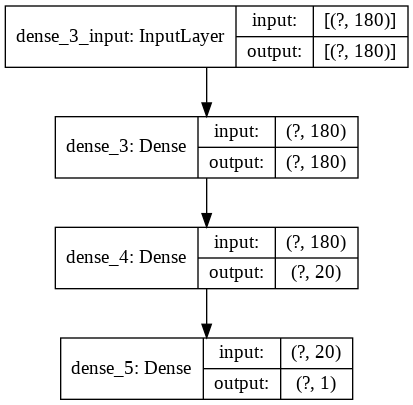

In [41]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

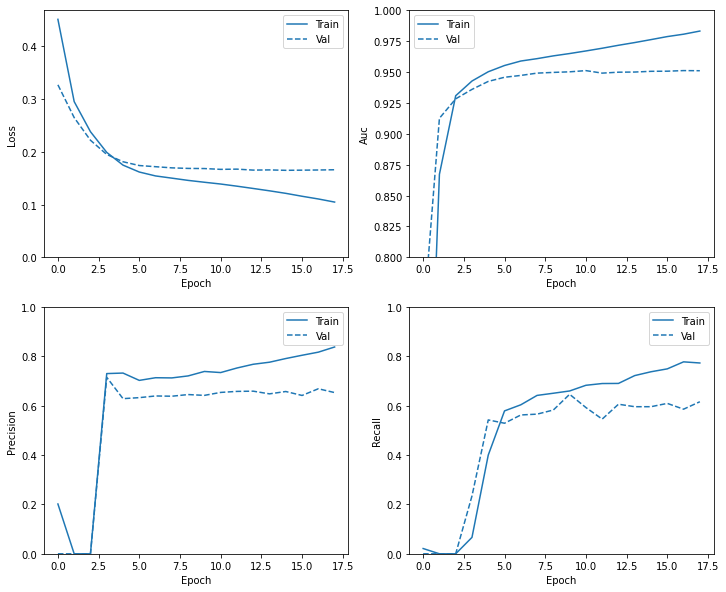

In [42]:
plot_metrics(history)

3/3 [==============================] - 0s 6ms/step - loss: 0.1659 - accuracy: 0.9225 - precision: 0.6525 - recall: 0.6154 - auc: 0.9510
loss :  0.165949285030365
loss :  0.165949285030365
accuracy :  0.9224891066551208
precision :  0.652482271194458
recall :  0.6153846383094788
auc :  0.9510086178779602

Undetected Classified Correctly (True Negatives):  2351
Undetected Classified as Detected (False Positives):  98
Detected Classified as Undetected (False Negatives):  115
Detected Classified Correctly (True Positives):  184
Total Detected Peptides:  299


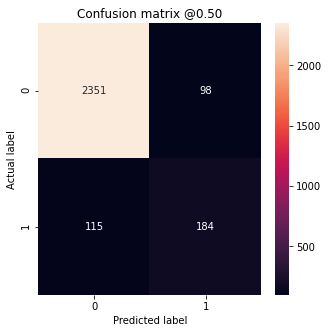

In [43]:
evaluate_model(model, val_tuple[0], val_tuple[1])

3/3 [==============================] - 0s 5ms/step - loss: 0.1551 - accuracy: 0.9298 - precision: 0.6755 - recall: 0.6823 - auc: 0.9578
loss :  0.15510651469230652
loss :  0.15510651469230652
accuracy :  0.9297926425933838
precision :  0.6754966974258423
recall :  0.6822742223739624
auc :  0.957808256149292

Undetected Classified Correctly (True Negatives):  2352
Undetected Classified as Detected (False Positives):  98
Detected Classified as Undetected (False Negatives):  95
Detected Classified Correctly (True Positives):  204
Total Detected Peptides:  299


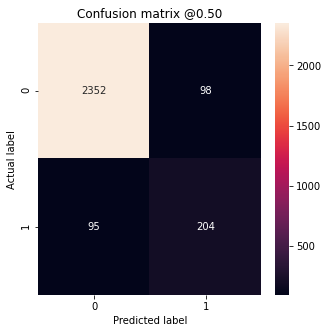

In [44]:
evaluate_model(model, test_tuple[0], test_tuple[1])

# Test Model on the Covid-19 Spike Peptides

In [56]:
# First, Train model on the whole training data, our picked model don't use class weights
whole_data_ds = get_whole_training_data_ds()
model = get_model()
model.fit(whole_data_ds, epochs=EPOCHS)

Whole data:
Examples:
    Total: 27483
    Positive: 2991 (10.88% of total)

Mean positive rate in ds is: 10.97% with STD of 12.31%

Epoch 1/50
27/27 [==============================] - 0s 10ms/step - loss: 0.4725 - accuracy: 0.8603 - precision: 0.1522 - recall: 0.0620 - auc: 0.3637
Epoch 2/50
27/27 [==============================] - 0s 10ms/step - loss: 0.3060 - accuracy: 0.8912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7815
Epoch 3/50
27/27 [==============================] - 0s 11ms/step - loss: 0.2592 - accuracy: 0.8912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9021
Epoch 4/50
27/27 [==============================] - 0s 11ms/step - loss: 0.2309 - accuracy: 0.8912 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9195
Epoch 5/50
27/27 [==============================] - 0s 11ms/step - loss: 0.2112 - accuracy: 0.8912 - precision: 1.0000 - recall: 6.6867e-04 - auc: 0.9298
Epoch 6/50
27/27 [==============================] - 0s 11ms/step - loss: 0.1989 - accurac

In [67]:
from itertools import groupby
# Load "the" test data
def fastaread(fasta_name):
    """
    Read a fasta file. For each sequence in the file, yield the header and the actual sequence.
    In Ex1 you may assume the fasta files contain only one sequence.
    You may keep this function, edit it, or delete it and implement your own reader.
    """
    f = open(fasta_name)
    faiter = (x[1] for x in groupby(f, lambda line: line.startswith(">")))
    for header in faiter:
        header = next(header)[1:].strip()
        seq = "".join(s.strip() for s in next(faiter))
        yield header, seq


fasta_file = 'P0DTC2.fasta'
sequence = next(fastaread(fasta_file))[1]

# cut all peptides
peptides = [sequence[i:i+9] for i in range(len(sequence)-8)]
covid_peptides = pd.DataFrame(peptides,columns=['peptide'])
display(covid_peptides.head())
X = encode_features(covid_peptides)
X.head()


,peptide
0,MFVFLVLLP
1,FVFLVLLPL
2,VFLVLLPLV
3,FLVLLPLVS
4,LVLLPLVSS


,amino_0_A,amino_0_C,amino_0_D,amino_0_E,amino_0_F,amino_0_G,amino_0_H,amino_0_I,amino_0_K,amino_0_L,amino_0_M,amino_0_N,amino_0_P,amino_0_Q,amino_0_R,amino_0_S,amino_0_T,amino_0_V,amino_0_W,amino_0_Y,amino_1_A,amino_1_C,amino_1_D,amino_1_E,amino_1_F,amino_1_G,amino_1_H,amino_1_I,amino_1_K,amino_1_L,amino_1_M,amino_1_N,amino_1_P,amino_1_Q,amino_1_R,amino_1_S,amino_1_T,amino_1_V,amino_1_W,amino_1_Y,...,amino_7_A,amino_7_C,amino_7_D,amino_7_E,amino_7_F,amino_7_G,amino_7_H,amino_7_I,amino_7_K,amino_7_L,amino_7_M,amino_7_N,amino_7_P,amino_7_Q,amino_7_R,amino_7_S,amino_7_T,amino_7_V,amino_7_W,amino_7_Y,amino_8_A,amino_8_C,amino_8_D,amino_8_E,amino_8_F,amino_8_G,amino_8_H,amino_8_I,amino_8_K,amino_8_L,amino_8_M,amino_8_N,amino_8_P,amino_8_Q,amino_8_R,amino_8_S,amino_8_T,amino_8_V,amino_8_W,amino_8_Y
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [100]:
prediction = model.predict(X)
covid_peptides['Prob'] = prediction.round(5)

In [103]:
covid_peptides = covid_peptides.sort_values(by='Prob', ascending=False)
covid_peptides.head()

,peptide,Prob
400,VIRGDEVRQ,0.93973
875,ALLAGTITS,0.92006
187,NLREFVFKN,0.85689
334,LCPFGEVFN,0.84212
299,KCTLKSFTV,0.83915


In [77]:
|# detected Covid peptides are: 
detected_by_model = covid_peptides[prediction]
detected_by_model

,peptide
3,FLVLLPLVS
78,FDNPVLPFN
116,LLIVNNATN
134,FCNDPFLGV
174,FLMDLEGKQ
187,NLREFVFKN
210,NLVRDLPQG
224,PLVDLPIGI
226,VDLPIGINI
240,LLALHRSYL
